In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import scipy

from ee102b_utilities import *

## Load and Visualize Data

In [3]:
# open the data file, inspect data fields
ds = xr.open_dataset("radar_noisy_firsthalf.nc")
ds

<xarray.Dataset>
Dimensions:               (fast_time: 3200, slow_time: 2500)
Coordinates:
  * fast_time             (fast_time) float64 0.0 2e-08 ... 6.396e-05 6.398e-05
  * slow_time             (slow_time) float64 0.0 0.05128 0.1026 ... 128.1 128.2
Data variables:
    reference_chirp_real  (fast_time) float64 ...
    reference_chirp_imag  (fast_time) float64 ...
    data                  (slow_time, fast_time) int32 ...
    bed_pick              (slow_time) int64 ...
Attributes:
    fs:       50000000.0
    prf:      19.5

Unfiltered Average SNR = 26.65 dB


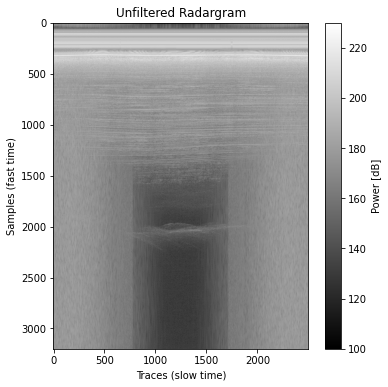

In [4]:
# view unfiltered radargram
pulse_compressed = pulse_compress(ds)
plot_radargram(pulse_compressed, title="Unfiltered Radargram")

snr_unfiltered, snr_avg_unfiltered = estimate_snr(pulse_compressed, ds["bed_pick"])
snr_avg_unfiltered = 10*np.log10(snr_avg_unfiltered)
print('Unfiltered Average SNR = %.2f dB' % snr_avg_unfiltered)

It's hard to see the bed reflection throughout this radargram and there's clearly some noise corrupting the data. The average SNR is okay, but SNR alone doesn't mean much if we can't see the bed. 

## Try a Simple Lowpass Filter

We know the bandwidth of the radar system is 15 MHz, so a reasonable initial guess might be that our signal will be contained entirely in the 0-15 MHz range. Let's implement a lowpass filter with a cutoff frequency of 15 MHz and apply it to the radargram to see if we can reduce some of this noise and improve the SNR and interprebility of our data.  

In [5]:
# build simple lowpass filter
lowpass_filter = scipy.signal.butter(4, 15e6, btype='lowpass', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 26.15 dB


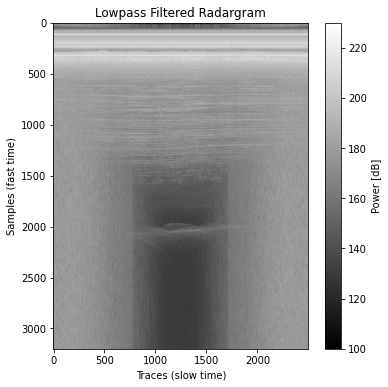

In [6]:
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    trace_filtered = scipy.signal.sosfilt(lowpass_filter, trace_unfiltered)
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

Hmmm. That didn't really do much. You'll have to get fancier and look at the noise characteristics and design filters specific to that. Happy filtering!

## Investigate Noise Characteristics, Design & Apply Filters

In [ ]:
# look at noise characteristics (e.g. compute spectrogram) fill in TODOs in framework below

3200
3200


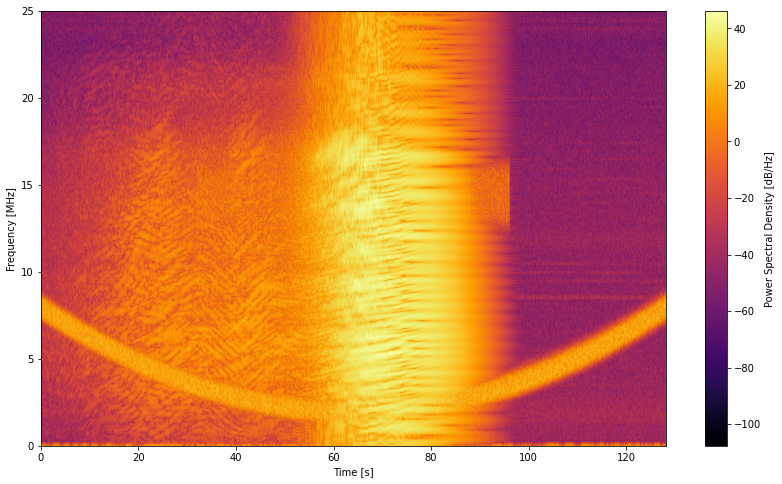

In [44]:
window = scipy.signal.gaussian(3200,90)
#scipy.signal.kaiser(3200,150)
#scipy.signal.chebwin(3200,4000)

print(len(window))
print(len(ds.fast_time))
spectrogram_options = {
    "fs": ds.fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 1,
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}
f, t, Sxx_test = scipy.signal.spectrogram(ds["data"].to_numpy().flatten(), **spectrogram_options)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
p = plt.pcolormesh(ds["slow_time"], f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
clb = fig.colorbar(p, ax=ax)
clb.set_label('Power Spectral Density [dB/Hz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [MHz]')
plt.show()

In [ ]:
# apply filters that address the noise you see in the radargram (see above for example filter application if needed)
# use the visual quality of the radargram and the SNR as metrics for how well you are doing

In [84]:
# build filter
lowpass_filter = scipy.signal.ellip(4, 1, 80, 15e6, btype='lowpass', output='sos', fs=ds.fs)
#scipy.signal.butter(5, 15e6, btype='lowpass', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 26.36 dB


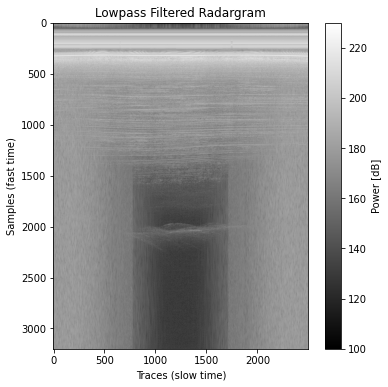

In [85]:
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    trace_filtered = scipy.signal.sosfilt(lowpass_filter, trace_unfiltered)
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)